#### Desafio DHAUZ - Ciência de Dados

##### *Contexto:*
Você foi contratado pela DHAUZ como cientista de dados para analisar uma base de dados de clientes de uma rede de Hotéis. Sua tarefa é investigar os dados em busca de insights que possam ajudar a empresa a evitar cancelamentos e também construir um modelo preditivo que possa antecipar esses cancelamentos, de modo que a empresa tenha tempo hábil para agir com ações de retenção.

##### *Questões Avaliadas:*

[a) Elabore hipóteses e visualizações envolvendo a variável cancellation e, pelo menos, outras duas variáveis presentes no dataset;](#a-elabore-hipóteses-e-visualizações)

[b) Desenvolva um modelo preditivo de classificação para identificar cancelamentos e utilize métricas adequadas para argumentar a efetividade do modelo;](#b-desenvolva-um-modelo-preditivo)

[c) Ao realizar a validação cruzada do modelo de classificação, discuta sobre as diferenças entre utilizar uma separação entre treino e teste aleatória e uma separação temporal (Ex: treino em 2015 e 2016 e validação em 2017). Os resultados são diferentes? Qual o mais indicado?](#c-validação-cruzada)


--------------

##### Biblbiotecas Relevantes 

In [48]:
#Basic Packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns  
import datetime
import missingno as msno 
import janitor 
import optuna
from scipy.stats import ks_2samp

#Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, classification_report
from lightgbm import LGBMClassifier



sns.set_style(style= 'whitegrid')

-------

#### Importação dos Dados e Avaliação Inicial da Base

- Nessa seção, vamos realizar a importação dos dados relevantes para a análise de cancelamentos e realizar uma pré-avaliação da qualidade da base de dados.

 - Isso incluirá a verificação da consistência dos tipos de dados, identificação de valores ausentes (NA's) ou inconsistentes, e uma análise descritiva básica para entender melhor a distribuição das variáveis!

In [49]:
#Importação da base de Cancelamentos 

df_cancelamentos = pd.read_csv(
    'cancellation_prediction.csv'
)

#Garantindo que as colunas do dataframe estão padronizadas
df_cancelamentos = df_cancelamentos.clean_names()

df_cancelamentos.head(5)

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,id_travel_agency_booking,id_person_booking,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
0,Fancy Hotel,0,342,2015,July,27,1,0,0,2,...,0,C,3,No Deposit,NaN,NaN,0,0.0,0,0
1,Fancy Hotel,0,737,2015,July,27,1,0,0,2,...,0,C,4,No Deposit,NaN,NaN,0,0.0,0,0
2,Fancy Hotel,0,7,2015,July,27,1,0,1,1,...,0,A,0,No Deposit,NaN,NaN,0,75.0,0,0
3,Fancy Hotel,0,13,2015,July,27,1,0,1,1,...,0,A,0,No Deposit,304.0,NaN,0,75.0,0,0
4,Fancy Hotel,0,14,2015,July,27,1,0,2,2,...,0,A,0,No Deposit,240.0,NaN,0,98.0,0,1


In [50]:
# Descrição Gerla da Base

df_cancelamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   type                             119390 non-null  object 
 1   cancellation                     119390 non-null  int64  
 2   days_between_booking_arrival     119390 non-null  int64  
 3   year_arrival_date                119390 non-null  int64  
 4   month_arrival_date               119390 non-null  object 
 5   week_number_arrival_date         119390 non-null  int64  
 6   day_of_month_arrival_date        119390 non-null  int64  
 7   num_weekend_nights               119390 non-null  int64  
 8   num_workweek_nights              119390 non-null  int64  
 9   num_adults                       119390 non-null  int64  
 10  num_children                     119386 non-null  float64
 11  num_babies                       119390 non-null  int64  
 12  br

In [51]:
#Contagem dos valore ausentes por coluna

valores_ausentes  = pd.DataFrame(
        df_cancelamentos.isna().sum()
    ).rename(columns= {0: 'NA Count'})

valores_ausentes['NA % of Total'] = valores_ausentes['NA Count'].div(df_cancelamentos.shape[0]).mul(100).round(2)
valores_ausentes = valores_ausentes.sort_values(by = 'NA Count', ascending= False)
valores_ausentes

,NA Count,NA % of Total
id_person_booking,112593,94.31
id_travel_agency_booking,16340,13.69
country,488,0.41
num_children,4,0.00
type,0,0.00
distribution_channel,0,0.00
required_car_parking_spaces,0,0.00
avg_price,0,0.00
customer_type,0,0.00
deposit_policy,0,0.00


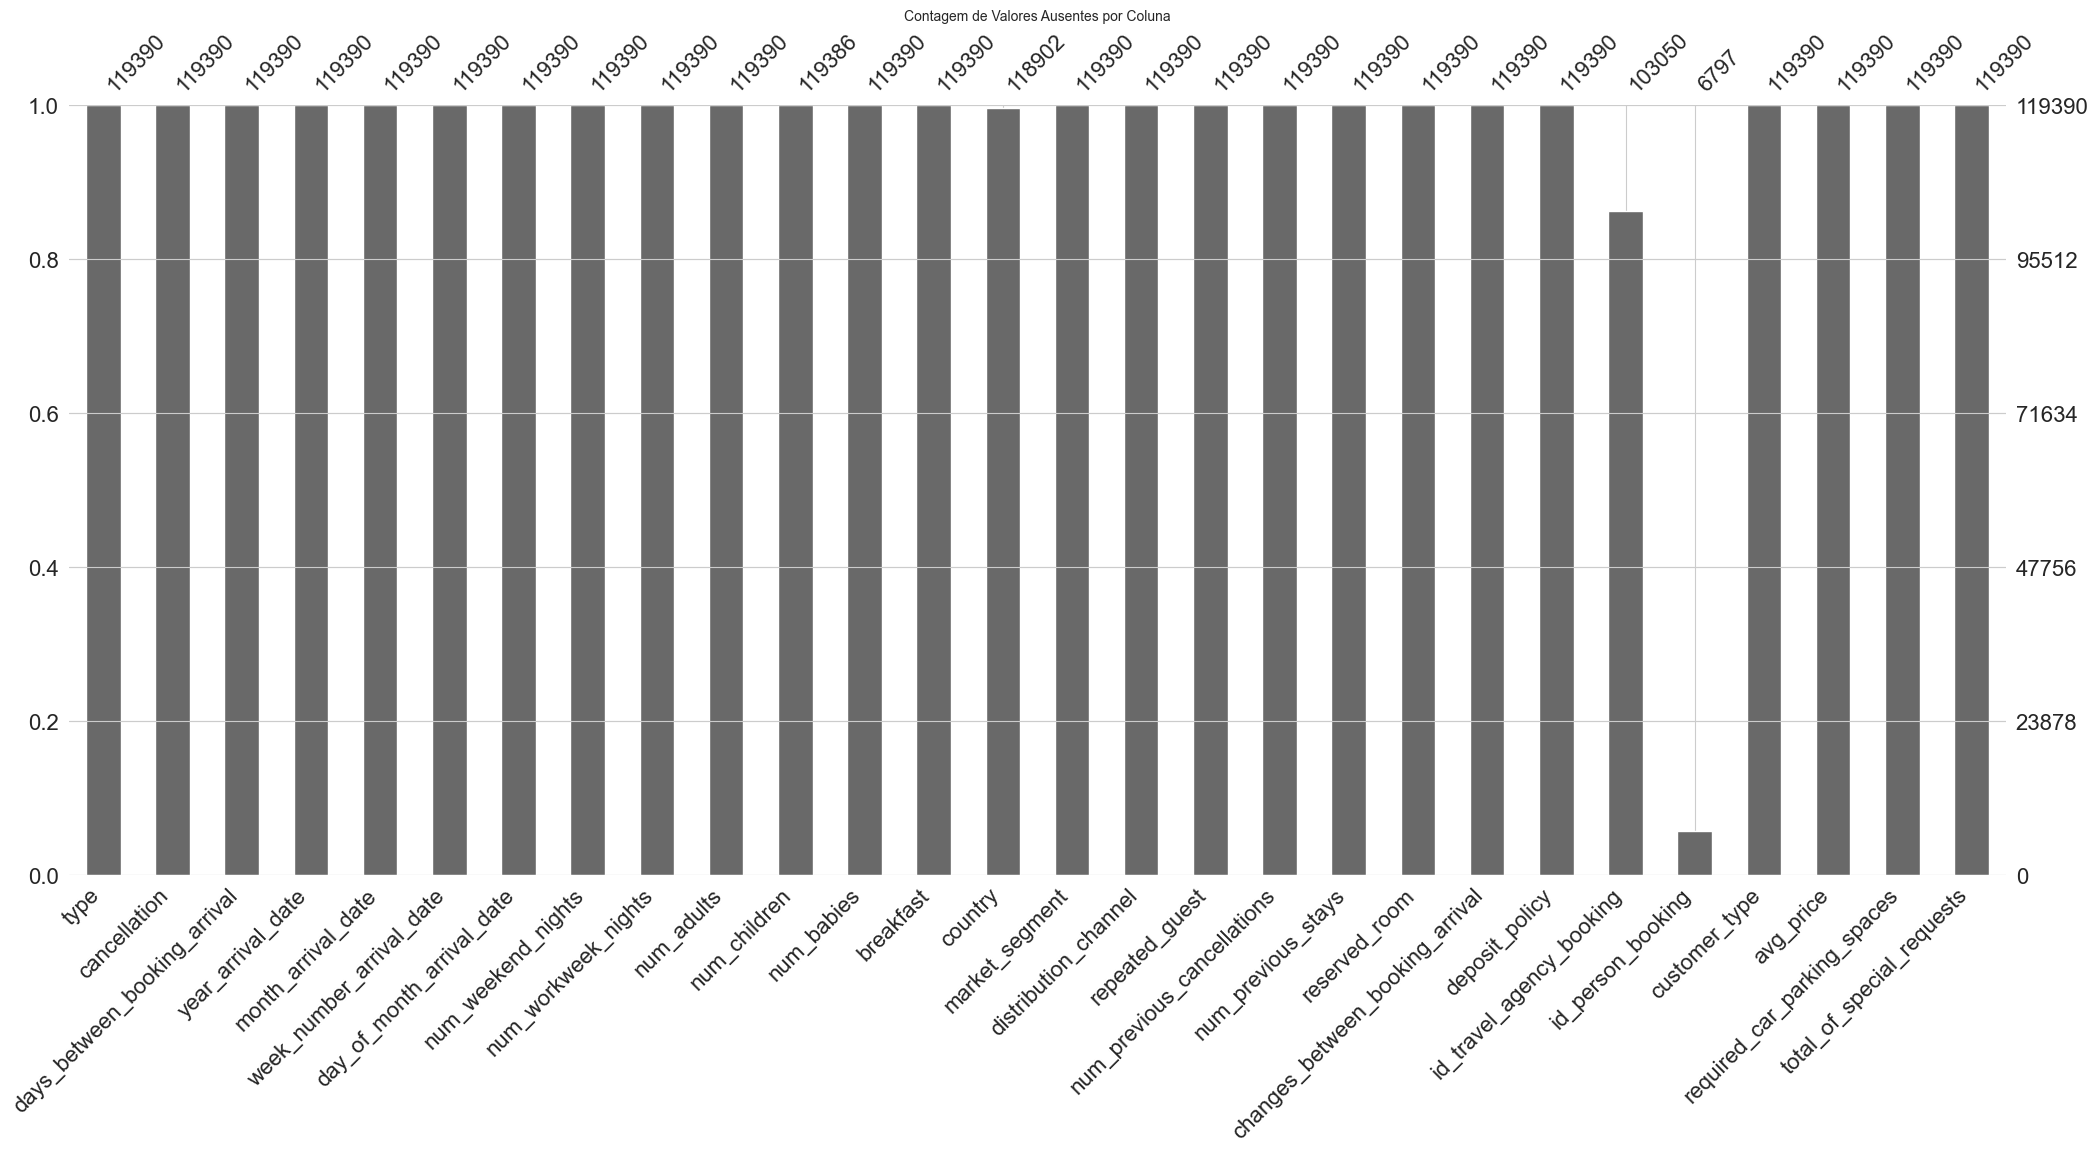

In [52]:
#Plotagem dos valores ausentes por coluna 
msno.bar(df_cancelamentos)
plt.title("Contagem de Valores Ausentes por Coluna", fontsize=10)  
plt.show()

In [53]:
#Contagem de valores zerados das variáveis numéricas 

valores_zerados = pd.DataFrame(
    (df_cancelamentos.select_dtypes(exclude= 'object') == 0 ).sum()
).rename(columns= {0:'Contagem de Zeros'})

valores_zerados['Contagem de Zeros (%)'] = valores_zerados['Contagem de Zeros']\
                                        .div(df_cancelamentos.shape[0]).mul(100).round(2)
                                        
valores_zerados = valores_zerados.sort_values(by = 'Contagem de Zeros', ascending= False)
valores_zerados

,Contagem de Zeros,Contagem de Zeros (%)
num_babies,118473,99.23
num_previous_stays,115770,96.97
repeated_guest,115580,96.81
num_previous_cancellations,112906,94.57
required_car_parking_spaces,111974,93.79
num_children,110796,92.80
changes_between_booking_arrival,101314,84.86
customer_type,89613,75.06
cancellation,75166,62.96
total_of_special_requests,70318,58.90


In [54]:
df_cancelamentos.shape

(119390, 28)

##### Primeiros Achados:

* Os tipos de dados estão consistentes entre as 28 variáveis do dataset

* As colunas `id_person_booking` apresenta um alto número de valores ausentes (94.31 %), seguido da coluna id `id_travel_agency_booking` (13.69 %). Como estas são colunas de identificação (id), pode-se opter pela sua exclusão sem que haja perdas para a modelagem futura. 

* As colunas `num_babies`, `num_previous_stays` e `repeated_guest` estão praticamente zeradas. A baixa cardinalidade não oferece ganhos para a modelagem que faremos futuramente, porém, por hora, iremos conservar essas colunas na base

* A coluna `Country` possui menos de 1% de valores ausentes. Sendo assim, remoções das linhas ausentes não afetaram a distribuição dos dados e nem a qualidade do modelo que construiremos futuramente

* Com as colunas de `year_arrival_date`, `month_arrival_date` e `day_of_month_arrival_date` é possível estruturar uma coluna de data de chegada 

* Com as colunas de `num_weekend_nights` e `num_workweek_nights` é possivel estimar a estadia prevista de cada cliente 

* Com a estadia prevista e a data de chegada é possível estivar a data de saída também 

In [55]:
#Transformações Iniciais

#Drop das colunas de ID
df_cancelamentos_ajustado = df_cancelamentos.drop(columns= ['id_person_booking', 'id_travel_agency_booking'])

#Drop das linas 
df_cancelamentos_ajustado = df_cancelamentos_ajustado.dropna()
df_cancelamentos_ajustado

,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,repeated_guest,num_previous_cancellations,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests
0,Fancy Hotel,0,342,2015,July,27,1,0,0,2,...,0,0,0,C,3,No Deposit,0,0.00,0,0
1,Fancy Hotel,0,737,2015,July,27,1,0,0,2,...,0,0,0,C,4,No Deposit,0,0.00,0,0
2,Fancy Hotel,0,7,2015,July,27,1,0,1,1,...,0,0,0,A,0,No Deposit,0,75.00,0,0
3,Fancy Hotel,0,13,2015,July,27,1,0,1,1,...,0,0,0,A,0,No Deposit,0,75.00,0,0
4,Fancy Hotel,0,14,2015,July,27,1,0,2,2,...,0,0,0,A,0,No Deposit,0,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,Hotel,0,23,2017,August,35,30,2,5,2,...,0,0,0,A,0,No Deposit,0,96.14,0,0
119386,Hotel,0,102,2017,August,35,31,2,5,3,...,0,0,0,E,0,No Deposit,0,225.43,0,2
119387,Hotel,0,34,2017,August,35,31,2,5,2,...,0,0,0,D,0,No Deposit,0,157.71,0,4
119388,Hotel,0,109,2017,August,35,31,2,5,2,...,0,0,0,A,0,No Deposit,0,104.40,0,0


In [56]:
#Total de valores ausentes após as transformações
total_de_na = df_cancelamentos_ajustado.isna().sum().sum()

print(f'Total de valores ausentes: {total_de_na}')

Total de valores ausentes: 0


In [57]:
# Criação da Coluna de Data

# Dicionário para mapear nomes de meses para números
meses = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

df_cancelamentos_ajustado['month_arrival_number'] = df_cancelamentos_ajustado['month_arrival_date'].map(meses)
df_cancelamentos_ajustado['arrival_date'] = df_cancelamentos_ajustado['year_arrival_date'].astype(str) + '-' \
                                             + df_cancelamentos_ajustado['month_arrival_number'].astype(str) + '-' \
                                             + df_cancelamentos_ajustado['day_of_month_arrival_date'].astype(str)
                                             
#Construção das Datas 
df_cancelamentos_ajustado['arrival_date'] =  pd.to_datetime(df_cancelamentos_ajustado['arrival_date'])
df_cancelamentos_ajustado['total_days_booked'] =  df_cancelamentos_ajustado['num_weekend_nights']  +   df_cancelamentos_ajustado['num_workweek_nights']
df_cancelamentos_ajustado['estimated_departure_date'] = df_cancelamentos_ajustado['arrival_date'] + pd.to_timedelta(df_cancelamentos_ajustado['total_days_booked'], unit='d')
df_cancelamentos_ajustado               

# Reordenamento
colunas = df_cancelamentos_ajustado.columns.tolist()
nova_ordem_colunas = colunas[-3:] + colunas[:-3]

# Reorganize as colunas do DataFrame de acordo com a nova ordem
df_cancelamentos_ajustado = df_cancelamentos_ajustado[nova_ordem_colunas]

# Exibir DataFrame com as colunas reorganizadas
df_cancelamentos_ajustado

,arrival_date,total_days_booked,estimated_departure_date,type,cancellation,days_between_booking_arrival,year_arrival_date,month_arrival_date,week_number_arrival_date,day_of_month_arrival_date,...,num_previous_cancellations,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests,month_arrival_number
0,2015-07-01,0,2015-07-01,Fancy Hotel,0,342,2015,July,27,1,...,0,0,C,3,No Deposit,0,0.00,0,0,7
1,2015-07-01,0,2015-07-01,Fancy Hotel,0,737,2015,July,27,1,...,0,0,C,4,No Deposit,0,0.00,0,0,7
2,2015-07-01,1,2015-07-02,Fancy Hotel,0,7,2015,July,27,1,...,0,0,A,0,No Deposit,0,75.00,0,0,7
3,2015-07-01,1,2015-07-02,Fancy Hotel,0,13,2015,July,27,1,...,0,0,A,0,No Deposit,0,75.00,0,0,7
4,2015-07-01,2,2015-07-03,Fancy Hotel,0,14,2015,July,27,1,...,0,0,A,0,No Deposit,0,98.00,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,2017-08-30,7,2017-09-06,Hotel,0,23,2017,August,35,30,...,0,0,A,0,No Deposit,0,96.14,0,0,8
119386,2017-08-31,7,2017-09-07,Hotel,0,102,2017,August,35,31,...,0,0,E,0,No Deposit,0,225.43,0,2,8
119387,2017-08-31,7,2017-09-07,Hotel,0,34,2017,August,35,31,...,0,0,D,0,No Deposit,0,157.71,0,4,8
119388,2017-08-31,7,2017-09-07,Hotel,0,109,2017,August,35,31,...,0,0,A,0,No Deposit,0,104.40,0,0,8


-----

#### a) Formulação de Hipóteses

- Na ciência de dados, a etapa de formulação de hipóteses é essencial para guiar a análise exploratória e a modelagem preditiva. Nesta fase, vamos explorar as potenciais relações entre variáveis, levantando pontos que podem corroborar ou refuturar as pressuposições de negócio.

In [58]:
#Describe da Base

df_cancelamentos_ajustado.select_dtypes(include= ['float', 'int']).\
    describe(percentiles= [.1,.25,.5,.75,.9]).T.drop(columns = ['count']).round(2)

,mean,std,min,10%,25%,50%,75%,90%,max
total_days_booked,3.43,2.54,0.0,1.00,2.0,3.0,4.0,7.0,57.0
cancellation,0.37,0.48,0.0,0.00,0.0,0.0,1.0,1.0,1.0
days_between_booking_arrival,104.31,106.90,0.0,3.00,18.0,69.0,161.0,265.0,737.0
year_arrival_date,2016.16,0.71,2015.0,2015.00,2016.0,2016.0,2017.0,2017.0,2017.0
week_number_arrival_date,27.17,13.59,1.0,8.00,16.0,28.0,38.0,46.0,53.0
day_of_month_arrival_date,15.80,8.78,1.0,4.00,8.0,16.0,23.0,28.0,31.0
num_weekend_nights,0.93,1.00,0.0,0.00,0.0,1.0,2.0,2.0,16.0
num_workweek_nights,2.50,1.90,0.0,1.00,1.0,2.0,3.0,5.0,41.0
num_adults,1.86,0.58,0.0,1.00,2.0,2.0,2.0,2.0,55.0
num_children,0.10,0.40,0.0,0.00,0.0,0.0,0.0,0.0,10.0


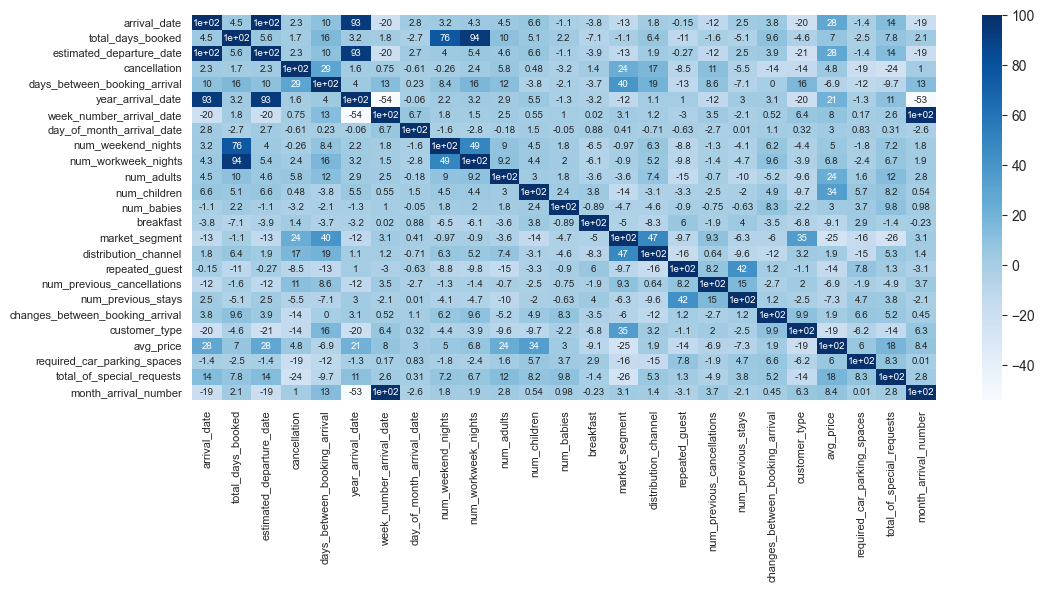

In [59]:
#Mapa de correlação Em escala 100

plt.figure(figsize=(12, 5))
heatmap = sns.heatmap(
    df_cancelamentos_ajustado.select_dtypes(exclude='object').corr().mul(100).round(2),
    annot=True,
    cmap='Blues',
    annot_kws={"size": 7}  
)

# Definindo o tamanho dos rótulos dos eixos x e y
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize=8)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize=8)

plt.show()

#### a.1) Hipóteses sobre a Variável `Cancellation`

In [60]:
#Visão Geral do Cancelamento

print("Proporção de cancelados e não canelados: ")
print(df_cancelamentos_ajustado.cancellation.value_counts(normalize= True).mul(100).round(4))


Proporção de cancelados e não canelados: 
cancellation
0    62.8648
1    37.1352
Name: proportion, dtype: float64


##### Hipotese 1: Será que existem periodos do ano onde o cancelamento é maior ou seja, é possível achar algum padrão de ciclicidade?

C:\Users\emmanuelsilva\AppData\Local\Temp\ipykernel_12692\2128455490.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


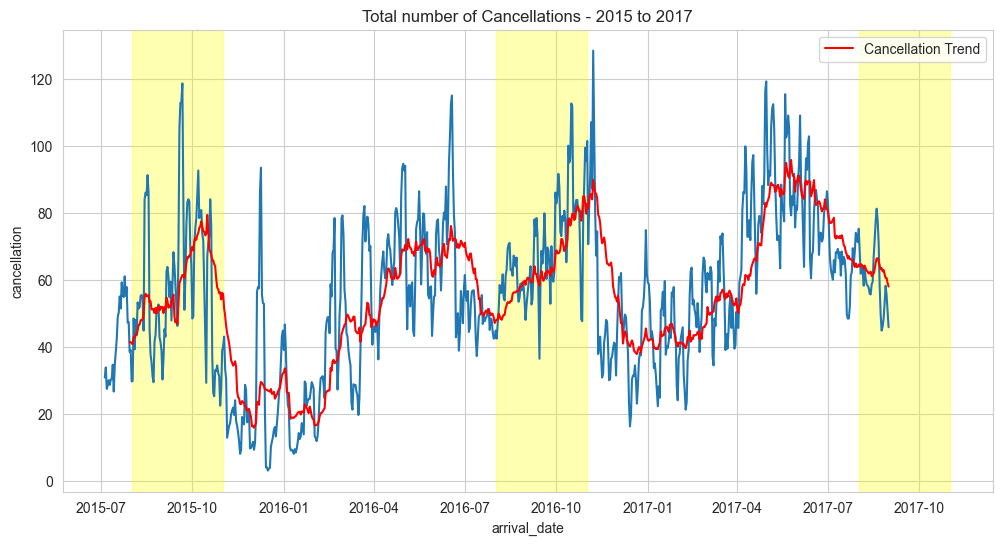

In [61]:
#Construção da serie temporal de cancelamentos
cancellation_trend = df_cancelamentos_ajustado.groupby(pd.Grouper(key='arrival_date', freq='D'))['cancellation'].sum()

#Suavizando a curva
rolling_cancellation_5_days = cancellation_trend.rolling(5).mean()
rolling_cancellation_30_days = cancellation_trend.rolling(30).mean()

plt.figure(figsize= (12,6))
plt.title('Total number of Cancellations - 2015 to 2017')
sns.lineplot(
    data = rolling_cancellation_5_days,
    palette= 'Blues'
)
plt.plot(rolling_cancellation_30_days, color = 'red', label = 'Cancellation Trend')

plt.axvspan('2015-08-01', '2015-11-01', color='yellow', alpha=0.3)  # Alpha define a transparência da faixa
plt.axvspan('2016-08-01', '2016-11-01', color='yellow', alpha=0.3)  # Alpha define a transparência da faixa
plt.axvspan('2017-08-01', '2017-11-01', color='yellow', alpha=0.3)  # Alpha define a transparência da faixa
plt.legend()
plt.show()

##### Hipotese 2: Será que existem paises que possuem maiores cancelamentos? E esse cancelamento varia de acordo com o tipo de hotel?

In [62]:
#Construção da tabela dinâmica

hotel_country_cancellation = pd.pivot_table(
                                data = df_cancelamentos_ajustado,
                                columns= 'type',
                                index= 'country',
                                values= 'cancellation',
                                aggfunc= 'mean'
                            ).mul(100).round(2).fillna(0)

hotel_country_cancellation['Mean_Cancellation'] = hotel_country_cancellation.mean(axis = 1).round(2)
hotel_country_cancellation = hotel_country_cancellation.sort_values(by = 'Mean_Cancellation', ascending= False)

hotel_country_cancellation.describe().round(2)

type,Fancy Hotel,Hotel,Mean_Cancellation
count,177.00,177.00,177.00
mean,14.13,32.65,23.39
std,24.30,31.86,22.97
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,27.08,19.76
75%,19.94,47.83,36.30
max,100.00,100.00,100.00


C:\Users\emmanuelsilva\AppData\Local\Temp\ipykernel_12692\661846657.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


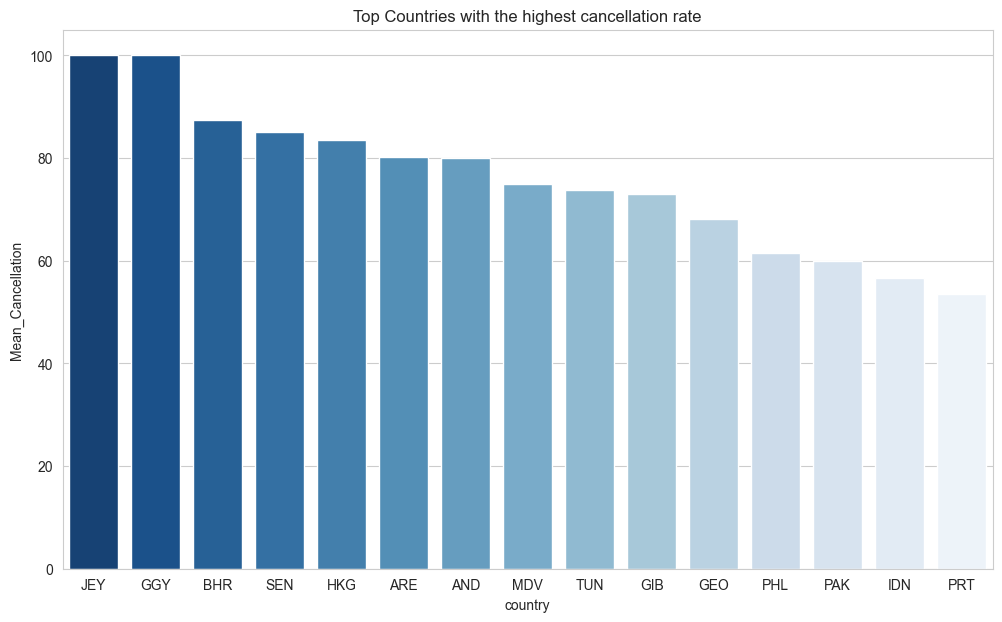

In [63]:
#Plotagem dos paises com os maiores níveis de Cancelamento

plt.figure(figsize = (12,7))
plt.title('Top Countries with the highest cancellation rate')
sns.barplot(
    data= hotel_country_cancellation['Mean_Cancellation'].T.head(15),
    palette = 'Blues_r'
)
plt.show()

##### Achados sobre a variável `Cancellations`:

- Aparentemnte, existe **picos de cancelamento em  epocas de final de ano (julho a agosto)** e baixas de cancelamento no início de ano (janeiro). Esse tipo de movimento é comum no setor de hotelaria onde existe temporadas de alta e baixa de demanda, onde o comportamento do consumidor é mais sólido e menos tendencioso ao cancelamento (Ex: ferias de verão)

- Foi visto que a média de cancelamentos de reservas de hoteis de luxo é menor que a de hoteis convencionais. Além disso, os maiores cnacelamentos estão presentes em países cujo território são em ilhas ou em regioões costeiras

####  a.2) Hipóteses sobre a Variável `avg_price`

##### Hipotese 1: Como o preço médio dos hoteis oscilaram ao longo do tempo? e se observarmos isso divido por tipo de hotel?

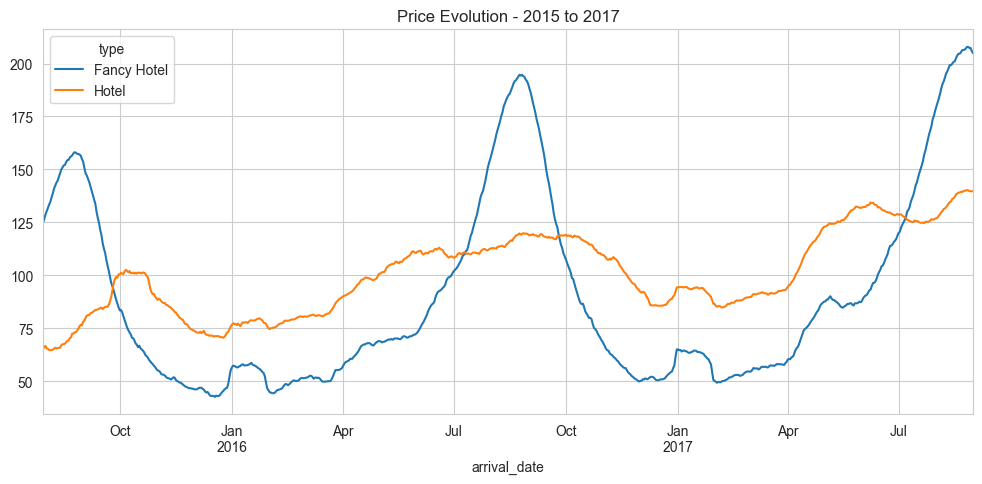

In [64]:
#Criando a serie temporal de preço e suavizando com médias moveis
price_trend = df_cancelamentos_ajustado.pivot_table(
    columns= 'type',
    index = pd.Grouper(key='arrival_date', freq='D'),
    values= 'avg_price'
).rolling(30).mean().dropna()


price_trend.plot(figsize= (12,5), title='Price Evolution - 2015 to 2017')
plt.show()

##### Hipotese 2: O preço é consistente por tipo de quarto, ou seja, quartos melhores tem preços mais altos ?

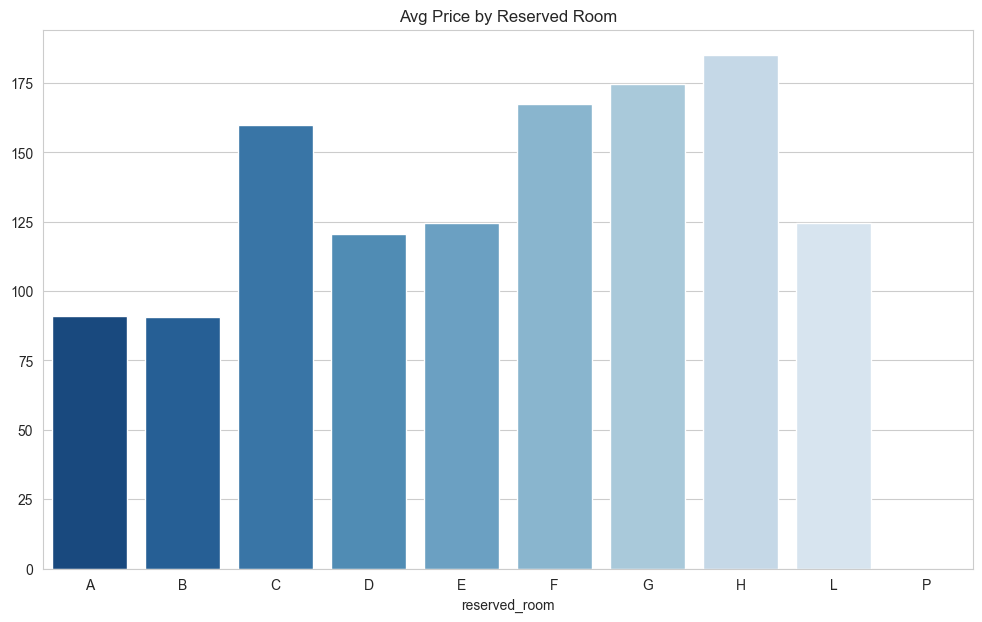

In [65]:
#O preço é consistente por tipo de quarto - quartos melhores tem preços mais altos ?

room_price = df_cancelamentos_ajustado.pivot_table(
    index = 'reserved_room',
    values= 'avg_price',
    aggfunc= 'mean' 
).round(2)


plt.figure(figsize = (12,7))
plt.title('Avg Price by Reserved Room')
sns.barplot(
    data= room_price.T,
    palette = 'Blues_r'
)
plt.show()

##### Achados sobre a variável `avg_price`:

- Foi visto que os preços das reservas **sobem mais ao final do ano** e decrescem no início do ano, revelando um comportamento ciclico de demanda por hoteis. também nota-se que o **preço dos hoteis de luxo flutuam de forma mais agressiva** quando comparados aos preços do hoteis convencionais 

- Outro ponto que foi percebido é que **existe uma tendência** de aumento nos preços das reservas dos hoteis ao longo do tempo, e que talvez esteja correlacionado com um processo inflacioário em curso

- Por fim o preço médio das reservas não acompanha o ranqueamento do nível do quarto disponível.  Um quarto `C`, por exemplo, é mais caro que um quarto nível `D` e `E` na média. Isso **pode indicar um problema de pricing** nos hoteis da rede 

#### a.3) Hipóteses sobre a Variável `Customer_type`

##### Hipotese 1: Existem tipos de clientes mais atrativos que outros? Ou seja, pagam um preço maior e ficam mais dias?

In [66]:
#Construção da tabela dinâmica de tipo de cliente 

customer_analysis = df_cancelamentos_ajustado.pivot_table(
    index = 'customer_type',
    values = ['avg_price','total_days_booked'],
    aggfunc= 'mean'
)
customer_analysis['Total Debt (Avarege)'] = customer_analysis['avg_price'] * customer_analysis['total_days_booked']
customer_analysis = customer_analysis.round(2)

customer_analysis

,avg_price,total_days_booked,Total Debt (Avarege)
customer_type,,,
0,107.10,3.45,369.67
1,87.55,5.32,465.82
2,86.09,3.06,263.71
3,83.97,2.89,243.06


C:\Users\emmanuelsilva\AppData\Local\Temp\ipykernel_12692\3113916212.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


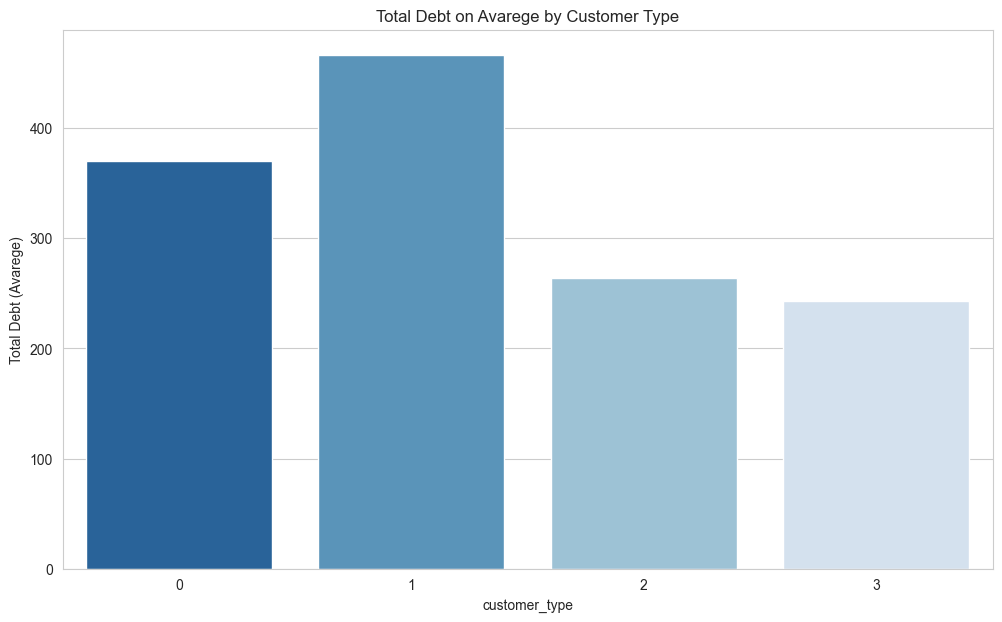

In [67]:
#Plot

plt.figure(figsize = (12,7))
plt.title('Total Debt on Avarege by Customer Type')
sns.barplot(
    data= customer_analysis['Total Debt (Avarege)'].T,
    palette = 'Blues_r'
)
plt.show()

##### Hipotese 2: Existem tipos de clientes que possuem um maior nível de cancelamento?

In [68]:
#Construção da tabela dinâmica de tipo de cliente 

customer_analysis = df_cancelamentos_ajustado.pivot_table(
    index = 'customer_type',
    values = ['cancellation'],
    aggfunc= 'mean'
)
customer_analysis = customer_analysis.round(2).mul(100)
customer_analysis

,cancellation
customer_type,
0,41.0
1,31.0
2,25.0
3,10.0


C:\Users\emmanuelsilva\AppData\Local\Temp\ipykernel_12692\2903048129.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


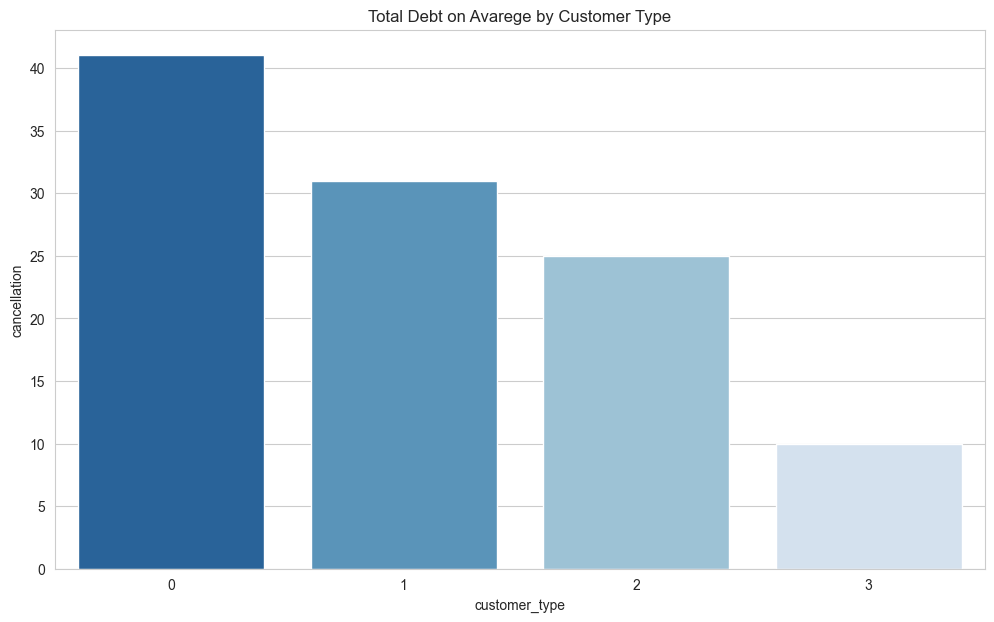

In [69]:
#Plot

plt.figure(figsize = (12,7))
plt.title('Total Debt on Avarege by Customer Type')
sns.barplot(
    data= customer_analysis['cancellation'].T,
    palette = 'Blues_r'
)
plt.show()

##### Achados sobre a variável `Customer_type`:

. Os clientes tipo `1` são os clientes **mais atrativos em termos de rentabilidade do negócio** em comparação aos outros tipos, pois a conta do hotel deles fecham em média em $465

. Porém se a preocupação de negócio for em torno do cancelamento, os clientes `3` podem ser um bom foco da empresa, uma vez que ele apresenta a menor taxa de cancelamento histórica em relação aos outros grupos

-------------

#### b) Modelo Preditivo de Cancelamento de Reservas

- Objetivo: Prever se uma reserva será cancelada ou não, com base em dados históricos e características da base de clientes fornecida. Sendo que, a reserva cancelada será representada por `1` e a reserva não cancelada `2`

- Proposta de Valor:Permitir que a empresa antecipe cancelamentos de reservas, **otimizando a estrutura de custos,maximizando a receita e/ou tomando ações preventivas** para reverter o cancelamento

- Agorítimo: `LightGBMClassifier`

- Metricas Avaliadas: Acurácia, sensibilidade, precisão, F1-Score, AUC ROC Score

obs: a escolha do LightGBM se deve à robustez dessa técnica. Sua eficiência no treinamento, menor dependência de scaling, capacidade de capturar padrões não lineares, redução de overfitting e manipulação  de grandes conjuntos de dados, o torna uma escolha atraente para problemas de modelagem preditiva

In [92]:
#Exclusão das datas brutas e gerar o dataframe da modelagem

df_modelo = df_cancelamentos_ajustado.copy()
df_modelo = df_modelo.sort_values(by = 'arrival_date', ascending= True)
df_modelo = df_modelo.drop(columns= ['arrival_date', 'estimated_departure_date', 'month_arrival_date'])
df_modelo

,total_days_booked,type,cancellation,days_between_booking_arrival,year_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,...,num_previous_cancellations,num_previous_stays,reserved_room,changes_between_booking_arrival,deposit_policy,customer_type,avg_price,required_car_parking_spaces,total_of_special_requests,month_arrival_number
0,0,Fancy Hotel,0,342,2015,27,1,0,0,2,...,0,0,C,3,No Deposit,0,0.0,0,0,7
75558,2,Hotel,0,257,2015,27,1,0,2,1,...,0,0,A,1,No Deposit,0,80.0,0,0,7
75559,2,Hotel,0,257,2015,27,1,0,2,1,...,0,0,A,1,No Deposit,0,80.0,0,0,7
75560,2,Hotel,0,257,2015,27,1,0,2,2,...,0,0,A,0,No Deposit,0,101.5,0,0,7
40060,2,Hotel,0,6,2015,27,1,0,2,1,...,0,0,A,0,No Deposit,0,0.0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13799,5,Fancy Hotel,1,45,2017,35,31,2,3,2,...,0,0,A,0,No Deposit,0,174.0,0,1,8
13798,4,Fancy Hotel,1,6,2017,35,31,1,3,2,...,0,0,D,0,No Deposit,0,207.5,0,0,8
13797,4,Fancy Hotel,1,13,2017,35,31,1,3,2,...,0,0,C,0,No Deposit,0,222.5,0,1,8
73712,7,Hotel,1,218,2017,35,31,2,5,3,...,0,0,D,0,No Deposit,0,162.0,0,0,8


In [93]:
#Preprocessing - Adicionando Features

df_modelo['Total_Debt'] = df_modelo['avg_price'] * df_modelo['total_days_booked']
df_modelo['Number_of_guests'] = df_modelo['num_adults'] +  df_modelo['num_children'] + df_modelo['num_babies']

#Encodando de forma ciclica o mês 
df_modelo['month_ciclical'] = np.sin(2 * np.pi * df_modelo['month_arrival_number']/12.0)

#Tratando as variáveis categóricas em dummy
df_modelo = pd.get_dummies(df_modelo)
df_modelo

,total_days_booked,cancellation,days_between_booking_arrival,year_arrival_date,week_number_arrival_date,day_of_month_arrival_date,num_weekend_nights,num_workweek_nights,num_adults,num_children,...,reserved_room_D,reserved_room_E,reserved_room_F,reserved_room_G,reserved_room_H,reserved_room_L,reserved_room_P,deposit_policy_No Deposit,deposit_policy_Non Refund,deposit_policy_Refundable
0,0,0,342,2015,27,1,0,0,2,0.0,...,False,False,False,False,False,False,False,True,False,False
75558,2,0,257,2015,27,1,0,2,1,0.0,...,False,False,False,False,False,False,False,True,False,False
75559,2,0,257,2015,27,1,0,2,1,0.0,...,False,False,False,False,False,False,False,True,False,False
75560,2,0,257,2015,27,1,0,2,2,0.0,...,False,False,False,False,False,False,False,True,False,False
40060,2,0,6,2015,27,1,0,2,1,0.0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13799,5,1,45,2017,35,31,2,3,2,0.0,...,False,False,False,False,False,False,False,True,False,False
13798,4,1,6,2017,35,31,1,3,2,1.0,...,True,False,False,False,False,False,False,True,False,False
13797,4,1,13,2017,35,31,1,3,2,2.0,...,False,False,False,False,False,False,False,True,False,False
73712,7,1,218,2017,35,31,2,5,3,0.0,...,True,False,False,False,False,False,False,True,False,False


In [94]:
#Dividingo o Dataset entre features e target

X = df_modelo.drop(columns = 'cancellation')
y = df_modelo.cancellation

In [95]:
#Checando o balanceamento de classes

df_modelo.cancellation.value_counts(normalize= True).mul(100).round(2)

cancellation
0    62.86
1    37.14
Name: proportion, dtype: float64

- Classes desbalanceadas podem enviesar modelos de classificação, deteriorando as métricas de performance. Para evitar esse problema, iremmos seguir com a biblioteca `imblearn` que possui algorítimos próprios para isso.

In [96]:
from imblearn.combine import SMOTEENN

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle= True,
    random_state=42)


#Corriding o o balanceamento com o SMOOTEEN
smt = SMOTEENN(random_state= 42)

X_res, y_res = smt.fit_resample(X_train, y_train)

In [97]:
# Selecionar features usando RFE
forest_model = LGBMClassifier(random_state= 42, n_estimators = 100, verbosity = -1)
forest_model.fit(X_res, y_res)

forest_importances = pd.Series(np.round(forest_model.feature_importances_ * 100,4) , index=X.columns)
forest_importances = forest_importances.sort_values(ascending = False)
forest_importances.head(15)

days_between_booking_arrival    34800
avg_price                       28000
Total_Debt                      19300
week_number_arrival_date        18100
market_segment                  14300
year_arrival_date               12700
day_of_month_arrival_date       11800
customer_type                   10500
country_PRT                     10400
total_of_special_requests       10100
month_ciclical                   8100
num_previous_cancellations       8100
required_car_parking_spaces      7600
Number_of_guests                 6600
deposit_policy_Non Refund        6200
dtype: int32

In [76]:
#Selecionar as 50 melhores features 

best_features = forest_importances.head(50)
X_train_selected = X_res[best_features.index]
X_test_selected = X_test[best_features.index]

In [77]:
#Otimização de Hiperparâmetros com cross validation

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),  # Ajuste o intervalo conforme necessário
    }
    
    model = LGBMClassifier(**params, verbosity = -1, random_state= 42)
    score = cross_val_score(model, X_train_selected, y_res, cv=5, scoring='roc_auc')
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials= 30)

best_params = study.best_params
print(best_params)

[I 2024-02-08 18:10:41,855] A new study created in memory with name: no-name-073bfd03-0473-43ac-8bda-a1fdf9b36ac4
[I 2024-02-08 18:10:48,995] Trial 0 finished with value: 0.9946080860214987 and parameters: {'num_leaves': 39, 'learning_rate': 0.1994713956732695, 'n_estimators': 323, 'max_depth': 11}. Best is trial 0 with value: 0.9946080860214987.
[I 2024-02-08 18:10:52,395] Trial 1 finished with value: 0.9856293020548161 and parameters: {'num_leaves': 25, 'learning_rate': 0.1462411023729569, 'n_estimators': 156, 'max_depth': 5}. Best is trial 0 with value: 0.9946080860214987.
[I 2024-02-08 18:10:58,830] Trial 2 finished with value: 0.9913970783462374 and parameters: {'num_leaves': 27, 'learning_rate': 0.08447247515552592, 'n_estimators': 349, 'max_depth': 13}. Best is trial 0 with value: 0.9946080860214987.
[I 2024-02-08 18:11:02,917] Trial 3 finished with value: 0.9848453717411406 and parameters: {'num_leaves': 22, 'learning_rate': 0.06532753777898373, 'n_estimators': 178, 'max_depth'

{'num_leaves': 40, 'learning_rate': 0.19813949940625, 'n_estimators': 498, 'max_depth': 18}


In [78]:
# Treinar o modelo final com os melhores hiperparâmetros 

modelo = LGBMClassifier(**best_params, random_state= 42, verbosity = -1) 
modelo.fit(X_train_selected, y_res)

LGBMClassifier(learning_rate=0.19813949940625, max_depth=18, n_estimators=498,
               num_leaves=40, random_state=42, verbosity=-1)

In [79]:
# Previsões probabilísticas no conjunto de teste
y_probs = modelo.predict_proba(X_test_selected)[:, 1]

# Calcular AUC
auc = roc_auc_score(y_test, y_probs,average = 'weighted')

# Avaliar o modelo no conjunto de teste
y_pred = modelo.predict(X_test_selected)
classification_rep = classification_report(y_test, y_pred)

# Exibir resultados
print("AUC:", np.round(auc,2), "\n")
print("Relatório de classificação:\n", classification_rep)

AUC: 0.93 

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89     14910
           1       0.81      0.80      0.81      8870

    accuracy                           0.86     23780
   macro avg       0.85      0.85      0.85     23780
weighted avg       0.86      0.86      0.86     23780



##### Interpretação dos Resultados:

. Em geral o modelo está com uma acuáraica relativamente boa (86%). O que significa que de a cada 100 predições feitas, 86 estão corretas.

. Analisando isoladamente o `F1-Score` de cada classe, é percebido que o modelo tem uma maior assertividade para as reservas **não canceladas** do que para aquelas reservas que se mostraram **canceladas**. Isso já era esperado devido ao desbalanceamento das classes, mas esse efeito já foi atenuado pelo `Imblearn`, que de forma bem sucessedida, conseguiu estabilizar as métricas.

##### Oportunidades e Lacunas de Negócio:

. O que aconteceria se conseguissemos **agir de forma proativa e reverter 30% dos cancelamentos** de reserva. Ou seja, quando o modelo detectasse um cancelamento, os times de negócio atuassem de maneira persuasiva, convencendo o cliente a permanecer com o agendamento? 

. Vamos fazer essa simulação abaixo:

In [80]:
# Analisando oportunidades por ano

lacuna_total = df_modelo[df_modelo['cancellation'] == 1].sum()

oportunidade = pd.DataFrame()
oportunidade['Lacuna Atual'] = lacuna_total / 3
oportunidade['Lacuna Simulada'] = oportunidade['Lacuna Atual'] * 0.7
oportunidade['Ganho'] = oportunidade['Lacuna Atual'] - oportunidade['Lacuna Simulada']

ganho = oportunidade.loc['Total_Debt']['Ganho']

print("Ganho ao reduzir 30% do cancelamento:", np.round(ganho, -4), "$ aproximadamente por ano")


Ganho ao reduzir 30% do cancelamento: 1670000.0 $ aproximadamente por ano


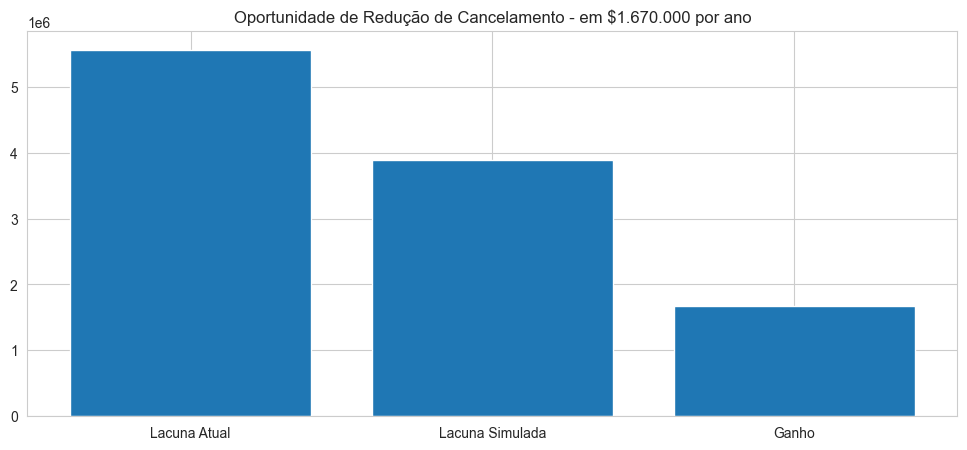

In [81]:
#plot

plt.figure(figsize = (12,5))
plt.title('Oportunidade de Redução de Cancelamento - em $1.670.000 por ano')
plt.bar(oportunidade.loc['Total_Debt'].index , height= oportunidade.loc['Total_Debt'].values)
plt.show()

------------

#### c) Abordagem Temporal do Modelo de Cancelamento:

- Nesta abordagem utilizaremos os dados de 2016 para treino do modelo e os dados de 2017 para realizar a teste do modelo, e em seguida discutiremos os resultados e as diferenças entre uma divisão de treino_teste aleatória e uma divisão temporal

In [82]:
#Treino e Teste


X_train = df_modelo.query("year_arrival_date == 2016").drop(columns = 'cancellation')
X_test = df_modelo.query("year_arrival_date == 2017").drop(columns = 'cancellation')
y_train = df_modelo.query("year_arrival_date == 2016").cancellation
y_test = df_modelo.query("year_arrival_date == 2017").cancellation

#Correção do Balanceamento
smt = SMOTEENN(random_state= 42)
X_res, y_res = smt.fit_resample(X_train, y_train)

In [91]:
# Selecionar features usando RFE
forest_model = LGBMClassifier(random_state= 42, n_estimators = 100, verbosity = -1)
forest_model.fit(X_res, y_res)

forest_importances = pd.Series(np.round(forest_model.feature_importances_ * 100,4) , index=X.columns)
forest_importances = forest_importances.sort_values(ascending = False)
forest_importances.head(15)

days_between_booking_arrival    33700
avg_price                       33400
Total_Debt                      19900
week_number_arrival_date        18700
market_segment                  14400
customer_type                   13800
day_of_month_arrival_date       13200
month_ciclical                  11100
total_of_special_requests        9600
country_PRT                      9300
required_car_parking_spaces      7700
Number_of_guests                 7600
num_workweek_nights              7200
total_days_booked                6600
deposit_policy_Non Refund        6500
dtype: int32

In [84]:
#Selecionar as 50 melhores features 

best_features = forest_importances.head(50)
X_train_selected = X_res[best_features.index]
X_test_selected = X_test[best_features.index]

In [85]:
#Otimização de Hiperparâmetros com cross validation

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),  # Ajuste o intervalo conforme necessário
    }
    
    model = LGBMClassifier(**params, verbosity = -1, random_state= 42)
    score = cross_val_score(model, X_train_selected, y_res, cv=5, scoring='roc_auc')
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials= 30)

best_params = study.best_params
print(best_params)

[I 2024-02-08 18:15:57,343] A new study created in memory with name: no-name-2b2f9d54-e3f6-4d73-90ba-c37ba19aac3c
[I 2024-02-08 18:16:02,951] Trial 0 finished with value: 0.7713749111876694 and parameters: {'num_leaves': 23, 'learning_rate': 0.17100507689130295, 'n_estimators': 312, 'max_depth': 15}. Best is trial 0 with value: 0.7713749111876694.
[I 2024-02-08 18:16:06,804] Trial 1 finished with value: 0.749861512451875 and parameters: {'num_leaves': 22, 'learning_rate': 0.06372981839755502, 'n_estimators': 177, 'max_depth': 8}. Best is trial 0 with value: 0.7713749111876694.
[I 2024-02-08 18:16:12,782] Trial 2 finished with value: 0.7717151640433131 and parameters: {'num_leaves': 31, 'learning_rate': 0.1395869190314929, 'n_estimators': 355, 'max_depth': 15}. Best is trial 2 with value: 0.7717151640433131.
[I 2024-02-08 18:16:17,848] Trial 3 finished with value: 0.7541960084611087 and parameters: {'num_leaves': 21, 'learning_rate': 0.07465208508137436, 'n_estimators': 404, 'max_depth'

{'num_leaves': 40, 'learning_rate': 0.19304510011271075, 'n_estimators': 482, 'max_depth': 14}


In [86]:
# Treinar o modelo final com os melhores hiperparâmetros 

modelo = LGBMClassifier(**best_params, random_state= 42, verbosity = -1) 
modelo.fit(X_train_selected, y_res)

LGBMClassifier(learning_rate=0.19304510011271075, max_depth=14,
               n_estimators=482, num_leaves=40, random_state=42, verbosity=-1)

In [87]:
# Previsões probabilísticas no conjunto de teste
y_probs = modelo.predict_proba(X_test_selected)[:, 1]

# Calcular AUC
auc = roc_auc_score(y_test, y_probs,average = 'weighted')

# Avaliar o modelo no conjunto de teste
y_pred = modelo.predict(X_test_selected)
classification_rep = classification_report(y_test, y_pred)

# Exibir resultados
print("AUC:", np.round(auc,2))
print("Relatório de classificação:\n", classification_rep)

AUC: 0.86
Relatório de classificação:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83     24870
           1       0.75      0.63      0.69     15734

    accuracy                           0.78     40604
   macro avg       0.77      0.75      0.76     40604
weighted avg       0.77      0.78      0.77     40604



In [88]:
#Teste de hipóteses de Kolmogorov-Smirnov para checar data drift

# Calcular a estatística KS e o p-valor
ks_statistic, p_value = ks_2samp(y_train, y_test)

# Definir o nível de significância
fator_alpha = 0.05

# Testar a hipótese nula de que as duas amostras vêm da mesma distribuição
print(f"Valor da estatística p: {np.round(p_value)}")

if p_value < fator_alpha:
    print("Há evidências estatísticas para rejeitar a hipótese nula. Data Drift encontrado.")
else:
    print("Não há evidências estatísticas para rejeitar a hipótese nula. Nenhuma mudança detectada.")

Valor da estatística p: 0.0
Há evidências estatísticas para rejeitar a hipótese nula. Data Drift encontrado.


##### Interpretação dos Resultados:

-  Após o ajuste temporal, percebe-se que a **acurácia geral do modelo decai para (78%)**. O que significa que de a cada 100 predições feitas, 78 estão corretas. Essa piora do resultado **é puxada principalmente pela classe das reservas canceladas**, que agora obedece uma lógica temporal. 

- Possivelmente está ocorrendo um **Data Drift**, onde os padrões dos dados onde o modelo foi treinado não são os mesmos padrões dos dados onde o modelo está sendo testado. O teste de hipóteses de Kolmogorov-Smirnov ajuda a comprovar esse fenõmeno e justificar, estatisticamente, a perda de performance do modelo

- Analisando isoladamente o `F1-Score` de cada classe, é percebido que o modelo de predição ainda tem uma maior assertividade para as reservas **não canceladas** do que para aquelas reservas que se mostraram **canceladas**. Porém agora, o F1-score da classe das reservas canceladas **está quase 10 pontos** percentuais menor em comparação ao primeiro modelo (onde os dados de treino e teste foram divididos aleatoriamente) 

##### Escolha do Modelo Mais Adequado:

- Apesar do primeiro modelo parecer mais atrativo pelas metricas analisadas, o **mais adequado é optar pelo segundo modelo**, onde a divisão entre treino e teste é feita temporalmente.

- Para situações de negócio onde a ordem dos registros importam (como é o caso do desafio acima), um modelo que aprende com o passado para prever o futuro fornece uma estimativa mais realista das previsões e um melhor controle do viés temporal

- O ponto negativo é que esse tipo de modelagem está mais vunerável a efeitos de sazonalidades, anomalias temporais e drift de dados, o que pode comprometer a eficácia prática do sistema preditivo.


#### Considerações Finais:

- Em geral o modelo apresentou um desempenho acima de 75%, o que já pode ser considerado bom. No entanto, para garantir a sustentabilidade do sistema de previsão a longo prazo, é essencial implementar uma esteira de `MLops` para a produção completa do modelo."

- Ademais é necessário integrar o modelo dentro do `sistema de gestão do cliente`, ou seja, ele deve ser utilizado para a tomada de decisões estratégicas e preventivas, para que so assim, ele consiga gerar valor na prática.